In [1]:
import pandas as pd
import numpy as np

In [2]:
import torch

if torch.cuda.is_available():    

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [3]:
train = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv')
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
train['y'] = (train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis = 1) >0 ).astype(int)

In [5]:
min_len = (train['y']> 0).sum()
train_undersample = train[train['y'] == 0].sample(n=min_len, random_state=2020)
train_new = pd.concat([train[train['y'] > 0], train_undersample])

In [6]:
def text_cleaning(text):
    '''
    Cleans text into a basic form for NLP. Operations include the following:-
    1. Remove special charecters like &, #, etc
    2. Removes extra spaces
    3. Removes embedded URL links
    4. Removes HTML tags
    5. Removes emojis
    
    text - Text piece to be cleaned.
    '''
    template = re.compile(r'https?://\S+|www\.\S+') #Removes website links
    text = template.sub(r'', text)
    
    soup = BeautifulSoup(text, 'lxml') #Removes HTML tags
    only_text = soup.get_text()
    text = only_text
    
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    text = re.sub(r"[^a-zA-Z\d]", " ", text) #Remove special Charecters
    text = re.sub(' +', ' ', text) #Remove Extra Spaces
    text = text.strip() # remove spaces at the beginning and at the end of string
    return text

In [7]:
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
from collections import defaultdict

stop = stopwords.words('english')
train_new['comment_text'] = train_new['comment_text'].apply(text_cleaning)

In [8]:
s = train_new['comment_text'].apply(lambda x : len(str(x).split()))

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='comment_text', ylabel='Density'>

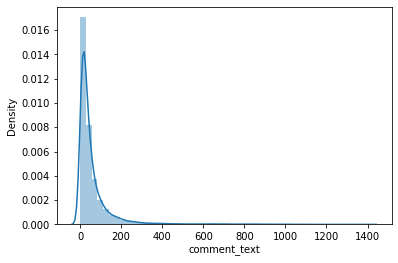

In [9]:
import seaborn as sns

sns.distplot(s)

In [10]:
train_new['comment_text'].head()

6          COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
12    Hey what is it talk What is it an exclusive gr...
16    Bye Don t look come or think of comming back T...
42    You are gay or antisemmitian Archangel WHite T...
43               FUCK YOUR FILTHY MOTHER IN THE ASS DRY
Name: comment_text, dtype: object

In [11]:
import sklearn
train_new['comment_text'], train_new['y'] = sklearn.utils.shuffle(train_new['comment_text'], train_new['y'], random_state = 2021)

In [12]:
import transformers

tokenizer = transformers.AutoTokenizer.from_pretrained('../input/huggingface-bert/bert-base-cased')

In [13]:
inputs = tokenizer(train_new['comment_text'].values.tolist(), padding =True, max_length = 160, truncation = True, add_special_tokens=True,return_attention_mask=True, return_tensors='pt')

In [14]:
# tokenizer.convert_ids_to_tokens(inputs['input_ids'][11]) 

In [15]:
len(inputs['input_ids'][0])

160

In [16]:
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [17]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

target = torch.tensor(train_new['y'].astype(np.float32).values)
train_data = TensorDataset(inputs['input_ids'], inputs['attention_mask'], target)
dataloader = DataLoader(train_data, batch_size = batch_size)

In [18]:
from transformers import TFBertModel, BertConfig, AdamW, BertModel,get_linear_schedule_with_warmup, BertForSequenceClassification
from tqdm.auto import tqdm


config = BertConfig.from_pretrained('../input/huggingface-bert/bert-base-cased', output_hidden_states = False)

model = BertForSequenceClassification.from_pretrained('../input/huggingface-bert/bert-base-cased', num_labels=1, output_hidden_states = False)

model.to(device)

optimizer = AdamW(model.parameters(), lr = 3e-5)
epochs = 4

total_steps = len(dataloader)*epochs

progress_bar = tqdm(range(total_steps))

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

loss_vals = []

for epoch in range(epochs):
    print('Training Epoch ', epoch)
    model.train()
    total_loss = 0
    
    for step, batch in enumerate(dataloader):
        batch_input_ids = batch[0].to(device)
        batch_input_mask = batch[1].to(device)
        batch_labels = batch[2].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(batch_input_ids, token_type_ids=None, attention_mask = batch_input_mask, labels = batch_labels)
#         print(outputs.keys()) # loss, logits
        
        loss = outputs[0].float()
        
        total_loss += loss.item()
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        
        scheduler.step()
        
        progress_bar.update(1)
        
    avg_epoch_loss = total_loss / len(dataloader)
    
    loss_vals.append(avg_epoch_loss)

    print("  Average training loss: {0:.2f}".format(avg_epoch_loss))

Some weights of the model checkpoint at ../input/huggingface-bert/bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from

  0%|          | 0/4060 [00:00<?, ?it/s]

Training Epoch  0
  Average training loss: 0.01
Training Epoch  1
  Average training loss: 0.01
Training Epoch  2
  Average training loss: 0.01
Training Epoch  3
  Average training loss: 0.02


In [19]:
test = pd.read_csv('../input/jigsaw-toxic-severity-rating/comments_to_score.csv')

In [20]:
test['text'] = test['text'].apply(text_cleaning)

In [21]:
test_inputs = tokenizer(test['text'].values.tolist(), padding =True, max_length = 160, truncation = True, add_special_tokens=True,return_attention_mask=True, return_tensors='pt')

In [22]:
test['target'] = 0
test['target'] = test['target'].astype(np.float32)

test_data = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], torch.tensor(test['target'].values))
test_dataloader = DataLoader(test_data, batch_size = batch_size)

In [23]:
test_preds = []

progress_bar2 = tqdm(range(len(test_dataloader)))

for step, batch in enumerate(test_dataloader):
    test_input_ids = batch[0].to(device)
    test_attention_mask = batch[1].to(device)
    test_labels = batch[2].to(device)
    
    with torch.no_grad():
        outputs = model(test_input_ids, token_type_ids=None, attention_mask = test_attention_mask, labels = test_labels)
        preds = outputs[1].detach().cpu().numpy()
        test_preds.append(preds)
    
    progress_bar2.update(1)

  0%|          | 0/236 [00:00<?, ?it/s]

In [24]:
test['target']= np.concatenate(test_preds, axis=0)

In [25]:
sub = pd.read_csv('../input/jigsaw-toxic-severity-rating/sample_submission.csv')

In [26]:
sub['score'] = test['target']
sub.to_csv('submission.csv', index = False)